# Introduction

ERDDAP rich responses and RESTful API is makes it **THE** most convenient way to serve data.

One can build URLs manually or programmatically like:

<small>`https://data.ioos.us/gliders/erddap/tabledap/blue-20160818T1448.csv?depth,temperature,time&time>=2017-02-10T00:00:00Z`</small>

- server: `https://data.ioos.us/gliders/erddap/`
- protocol: `tabledap`
- dataet_id: `blue-20160818T1448.csv`
- variables: `depth,latitude,longitude,temperature,time`
- constraints:
    - `time>=2016-07-10T00:00:00Z`
    - `time<=2017-02-10T00:00:00Z`
    - `latitude>=38.0`
    - `latitude<=41.0`
    - `longitude>=-72.0`
    - `longitude<=-69.0`

# `erddapy`'s goal is to make it easier to create the URLs

![tar.png](https://imgs.xkcd.com/comics/tar.png)

In [1]:
from erddapy import ERDDAP

server = 'https://data.ioos.us/gliders/erddap'

dataset_id = 'blue-20160818T1448'

constraints = {
    'time>=': '2016-07-10T00:00:00Z',
    'time<=': '2017-02-10T00:00:00Z',
    'latitude>=': 38.0,
    'latitude<=': 41.0,
    'longitude>=': -72.0,
    'longitude<=': -69.0,
}

variables = [
 'depth',
 'latitude',
 'longitude',
 'salinity',
 'temperature',
 'time',
]

In [2]:
e = ERDDAP(
    server=server,
    dataset_id=dataset_id,
    constraints=constraints,
    variables=variables,
    protocol='tabledap',
    response='mat',
)

print(e.get_download_url())

https://data.ioos.us/gliders/erddap/tabledap/blue-20160818T1448.mat?depth,latitude,longitude,salinity,temperature,time&time>=1468108800.0&time<=1486684800.0&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0


# Obtaining the data

There are a few methods to obtain the data with *to_pandas()* and *to_xarray()*:

In [3]:
df = e.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

In [4]:
df.head()

,depth,latitude,longitude,salinity,temperature
time,,,,,
2016-08-19 17:41:53,4.58,40.997572,-70.953544,32.241924,22.1122
2016-08-19 17:41:53,5.92,40.997572,-70.953544,32.231640,21.9331
2016-08-19 17:41:53,7.09,40.997572,-70.953544,32.225613,21.7394
2016-08-19 17:41:53,8.25,40.997572,-70.953544,32.231335,21.3219
2016-08-19 17:41:53,10.11,40.997572,-70.953544,32.286210,19.7151


# Let's plot the data

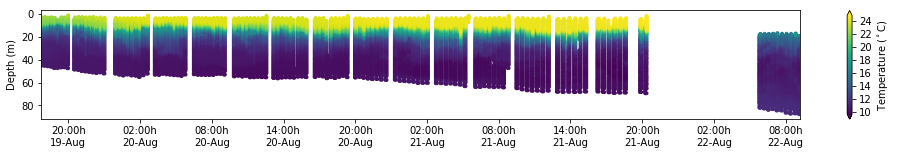

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['temperature'], marker='o', edgecolor='none')

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)');

# Exploring an ERDDAP server

In [6]:
from erddapy import ERDDAP


e = ERDDAP(
    server='https://data.ioos.us/gliders/erddap'
)

In [7]:
import pandas as pd


df = pd.read_csv(e.get_search_url(response='csv', search_for='all'))

In [8]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 293 tabledap, 0 griddap, and 0 wms endpoints.'

# We can refine our search

Let's narrow the search area, time span, and look for *sea_water_temperature* only.

In [9]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -72.0,
    'max_lon': -69.0,
    'min_lat': 38.0,
    'max_lat': 41.0,
    'min_time': '2016-07-10T00:00:00Z',
    'max_time': '2017-02-10T00:00:00Z',
    'cdm_data_type': 'trajectoryprofile'
}

In [10]:
search_url = e.get_search_url(response='csv', **kw)
search = pd.read_csv(search_url)
gliders = search['Dataset ID'].values

msg = 'Found {} Glider Datasets:\n\n{}'.format
print(msg(len(gliders), '\n'.join(gliders)))

Found 5 Glider Datasets:

blue-20160818T1448
cp_336-20170116T1254
silbo-20160413T1534
sp022-20170209T1616
whoi_406-20160902T1700


With the Dataset IDs we can explore the metadata with the *get_info_url*

In [11]:
print(gliders[0])

info_url = e.get_info_url(dataset_id=gliders[0], response='csv')
info = pd.read_csv(info_url)

info.head()

blue-20160818T1448


,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,acknowledgement,String,This deployment supported by NOAA U.S. IOOS
1,attribute,NC_GLOBAL,cdm_data_type,String,TrajectoryProfile
2,attribute,NC_GLOBAL,cdm_profile_variables,String,"profile_id, time, latitude, longitude, time_uv..."
3,attribute,NC_GLOBAL,cdm_trajectory_variables,String,"trajectory, wmo_id"
4,attribute,NC_GLOBAL,comment,String,Glider deployed by the University of Massachus...


In [12]:
cdm_profile_variables = info.loc[
    info['Attribute Name'] == 'cdm_profile_variables', 'Value'
]

print(''.join(cdm_profile_variables))

profile_id, time, latitude, longitude, time_uv, lat_uv, lon_uv, u, v


# Selecting variables by attributes

In [13]:
e.get_var_by_attr(
    dataset_id='blue-20160818T1448',
    standard_name='sea_water_temperature'
)

['temperature']

# Easy to use CF conventions standards

In [14]:
standard_name = lambda v: v is not None

variables = [
    e.get_var_by_attr(
        dataset_id=glider, standard_name=standard_name
    ) for glider in gliders
]

common_variables = set(variables[0]).intersection(*variables[1:])
', '.join(common_variables)

'conductivity, lat_uv_qc, lat_uv, v_qc, longitude, precise_time_qc, precise_time, time, v, latitude_qc, temperature, u, pressure, depth_qc, latitude, longitude_qc, conductivity_qc, density_qc, precise_lat, time_uv, salinity_qc, precise_lon, density, time_uv_qc, pressure_qc, lon_uv, temperature_qc, depth, lon_uv_qc, salinity, time_qc, u_qc'

# Putting everything together

In [15]:
from requests.exceptions import HTTPError

def download_csv(url):
    return pd.read_csv(
        url, index_col='time', parse_dates=True, skiprows=[1]
    )

dfs = {}
for glider in gliders:
    try:
        download_url = e.get_download_url(
            dataset_id=glider,
            protocol='tabledap',
            variables=common_variables,
            response='csv',
            constraints=constraints
        )
    except HTTPError:
        print('Failed to download {}'.format(glider))
        continue
    dfs.update({glider: download_csv(download_url)})

Failed to download silbo-20160413T1534
Failed to download sp022-20170209T1616


In [16]:
import numpy as np


for glider in dfs.keys():
    dfs[glider].loc[dfs[glider]['salinity_qc'] == 9, 'salinity'] = np.NaN
    dfs[glider].loc[dfs[glider]['pressure_qc'] == 9, 'pressure'] = np.NaN
    dfs[glider].loc[dfs[glider]['temperature_qc'] == 9, 'temperature'] = np.NaN
    dfs[glider].loc[dfs[glider]['salinity'] <= 0, 'salinity'] = np.NaN

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


dx = dy = 0.5
extent = kw['min_lon']-dx, kw['max_lon']+dx, kw['min_lat']+dy, kw['max_lat']+dy


def make_map(extent):
    fig, ax = plt.subplots(
        figsize=(9, 9),
        subplot_kw=dict(projection=ccrs.PlateCarree())
    )
    ax.coastlines(resolution='10m')
    ax.set_extent(extent)

    ax.set_xticks([extent[0], extent[1]], crs=ccrs.PlateCarree())
    ax.set_yticks([extent[2], extent[3]], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    return fig, ax

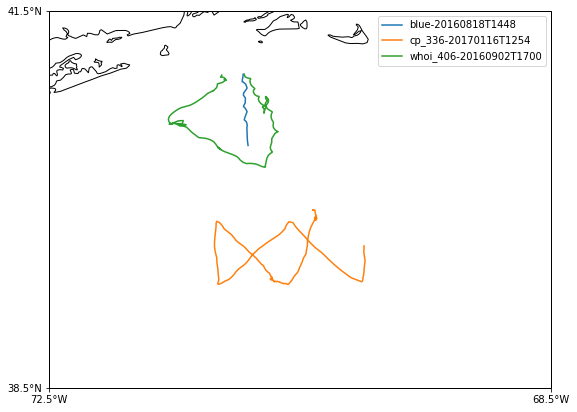

In [18]:
fig, ax = make_map(extent)
for glider, df in dfs.items():
    ax.plot(df['longitude'], df['latitude'], label=glider)

leg = ax.legend()

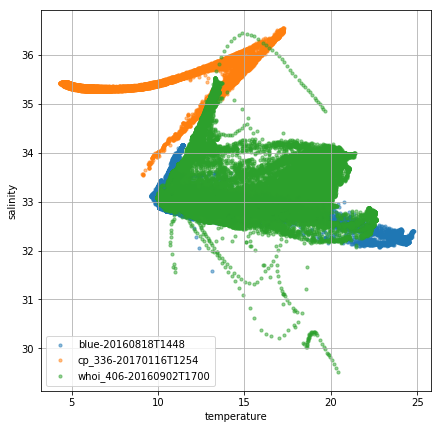

In [19]:
def glider_scatter(df, ax, glider):
    ax.scatter(df['temperature'], df['salinity'],
               s=10, alpha=0.5, label=glider)
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_ylabel('salinity')
ax.set_xlabel('temperature')
ax.grid(True)

for glider, df in dfs.items():
    glider_scatter(df, ax, glider)
leg = ax.legend()